# Imports

In [1]:
from google.cloud import bigquery
import pandas as pd
from pandas_profiling import ProfileReport
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
sns.set_style("darkgrid")
plt.rc("figure", figsize=(16, 12))
plt.rc("font", size=13)

# Reading Queries

In [2]:
total_signups_query = open('Queries/total_signups_query.sql', 'r').read()
signup_completed_query = open('Queries/signup_completed_query.sql', 'r').read()
devs_vetted_query = open('Queries/devs_vetted_query.sql', 'r').read()
devs_shortlisted_query = open('Queries/devs_shortlisted_query.sql', 'r').read()
devs_chosen_query = open('Queries/devs_chosen_query.sql', 'r').read()

# Useful Functions

In [33]:
def query_result(query):
    client = bigquery.Client('turing-230020')
    output = client.query(query).to_dataframe()
    client.close()
    return output

def stl_plot(df, trend, seasonal, residual):
    plt.subplot(411)
    plt.plot(df, label='Original', color="blue")
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend', color="blue")
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal, label='Seasonality', color="blue")
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals', color="blue")
    plt.legend(loc='best')
    plt.tight_layout()

def get_period(df):
    p_value_global = 0.05
    final_period = 0
    
    try:
        for period in (7, 14, 15, 28, 30, 182, 365):
            decomposition = seasonal_decompose(df['devs_count'], model='additive', period=period)
            residual = decomposition.resid

            p_value = stationarity_check(residual)

            if p_value < p_value_global:
                p_value_global = p_value
                final_period = period

        return final_period
    except:
        return final_period
    
def stationarity_check(residual):
    
    residual = residual.dropna()
    rolmean = residual.rolling(window = 8, center = False).mean()
    rolstd = residual.rolling(window = 8, center = False).std()
    dftest = adfuller(residual) 
    
    print ('Results of Dickey-Fuller Test:')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
    return dfoutput[1]

def apply_STL(period, df):
    decomposition = seasonal_decompose(df['devs_count'], model='additive', period=period)

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    print("Residual Mean and Standard Deviation -", np.mean(residual), "&", np.std(residual))
    
    stl_plot(df['devs_count'], trend, seasonal, residual)
    anomalies = get_anomalies(residual, seasonal, trend, df)
    
    return anomalies
    
def get_anomalies(resid, seasonal, trend, df):
    res_mean = resid.mean()
    resid_std = resid.std()

    lower_bound = res_mean - 3*resid_std
    upper_bound = res_mean + 3*resid_std

    cleaned_data = seasonal + trend

    plt.rc('font', size=12)
    fig, ax = plt.subplots(figsize=(15, 6))

    plt.plot(cleaned_data)
    plt.fill_between(list(cleaned_data.index), cleaned_data - lower_bound, cleaned_data + lower_bound, color = 'g', alpha = 0.15)

    ax.set_xlabel('Date')
    ax.set_ylabel('Devs Count')
    
    anomalies = df[(resid < lower_bound) | (resid > upper_bound)]
    anomalies['day_name'] = (anomalies.reset_index()['index'].dt.day_name()).values
    
    return anomalies

def data_preprocess(df):
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    df = df[df['date'] >= '2019-09-01']
    
    date_range = pd.date_range(df['date'].min(), df['date'].max())

    df = df.set_index('date')
    df = df.reindex(date_range, fill_value=0)
    df['mean'] = df.rolling(window=7).mean()
    
    return df


# Profiling

In [5]:
total_signups = query_result(total_signups_query)
total_signups = data_preprocess(total_signups)

ProfileReport(total_signups)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
signup_completed = query_result(signup_completed_query)
signup_completed = data_preprocess(signup_completed)

ProfileReport(signup_completed)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
devs_vetted = query_result(devs_vetted_query)
devs_vetted = data_preprocess(devs_vetted)

ProfileReport(devs_vetted)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
devs_shortlisted = query_result(devs_shortlisted_query)
devs_shortlisted = data_preprocess(devs_shortlisted)

ProfileReport(devs_shortlisted)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
devs_chosen = query_result(devs_chosen_query)
devs_chosen = data_preprocess(devs_chosen)

ProfileReport(devs_chosen)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# STL Decomposition

Results of Dickey-Fuller Test:
Test Statistic                -1.467876e+01
p-value                        3.180752e-27
#Lags Used                     2.200000e+01
Number of Observations Used    1.063000e+03
Critical Value (1%)           -3.436517e+00
Critical Value (5%)           -2.864263e+00
Critical Value (10%)          -2.568220e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.476732e+01
p-value                        2.351631e-27
#Lags Used                     2.200000e+01
Number of Observations Used    1.063000e+03
Critical Value (1%)           -3.436517e+00
Critical Value (5%)           -2.864263e+00
Critical Value (10%)          -2.568220e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.264679e+01
p-value                        1.396106e-23
#Lags Used                     2.200000e+01
Number of Observations Used    1.055000e+03
Critical Value (1%)           -3.436564e+00
Critical Value (5%)           -2.864283e+

/tmp/ipykernel_226/3564424832.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies['day_name'] = (anomalies.reset_index()['index'].dt.day_name()).values


devs_count         mean   day_name
2020-07-12 00:00:00+00:00        1268   241.000000     Sunday
2020-08-25 00:00:00+00:00        1602   280.000000    Tuesday
2021-06-10 00:00:00+00:00        3540  2057.428571   Thursday
2021-07-14 00:00:00+00:00        3665  2153.000000  Wednesday
2021-11-18 00:00:00+00:00        3510  1876.000000   Thursday
2021-12-16 00:00:00+00:00        6497  4820.000000   Thursday
2021-12-18 00:00:00+00:00        3000  4563.142857   Saturday
2021-12-31 00:00:00+00:00        2865  3953.142857     Friday
2022-01-20 00:00:00+00:00        7544  6210.142857   Thursday
2022-01-22 00:00:00+00:00        3925  6426.857143   Saturday
2022-01-23 00:00:00+00:00        3615  6145.142857     Sunday
2022-02-08 00:00:00+00:00        3531  3639.571429    Tuesday
2022-02-10 00:00:00+00:00        6813  4096.857143   Thursday
2022-02-11 00:00:00+00:00        6550  4511.142857     Friday
2022-02-13 00:00:00+00:00        3053  4571.428571     Sunday
2022-03-24 00:00:00+00:00        6485  5248.142857   Thursday
2022-03-26 00:00:00+00:00        2418  4876.285714   Saturday
2022-04-12 00:00:00+00:00        5564  3161.857143    Tuesday
2022-08-04 00:00:00+00:00        3125  1705.571429   Thursday
2022-08-06 00:00:00+00:00        1295  1871.857143   Saturday
2022-08-09 00:00:00+00:00        4052  2549.571429    Tuesday

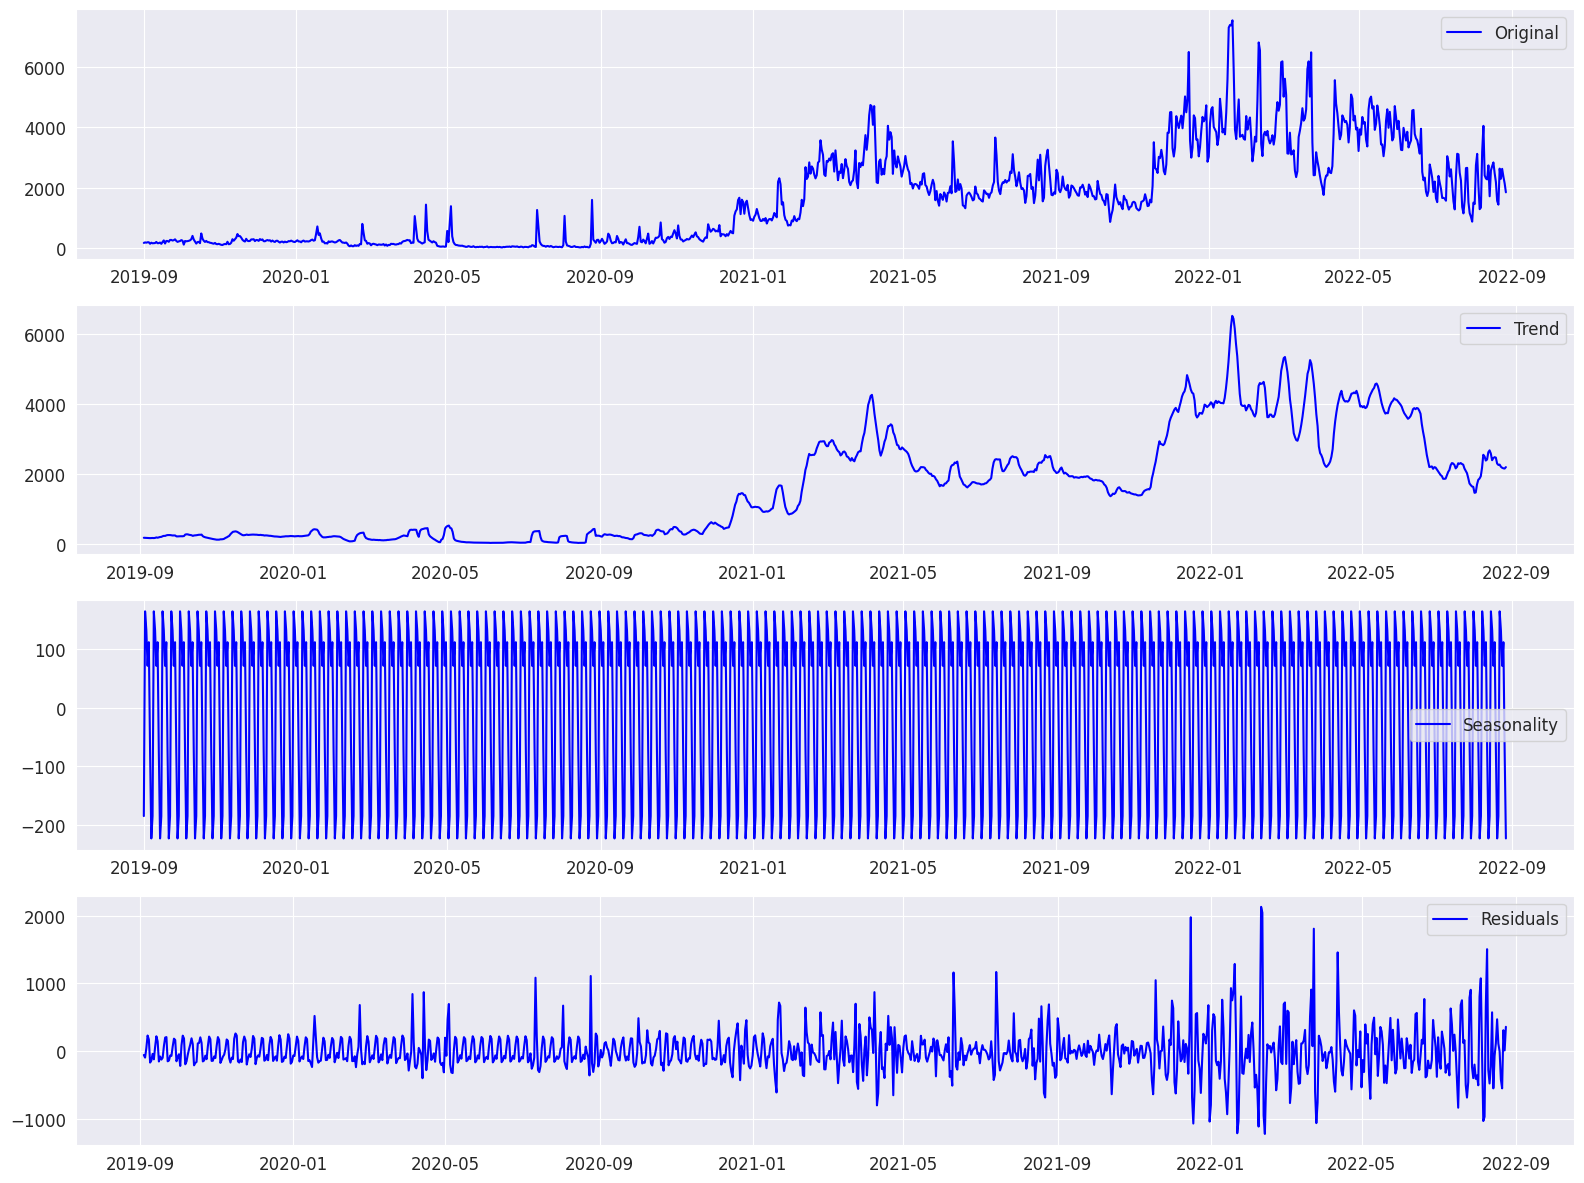

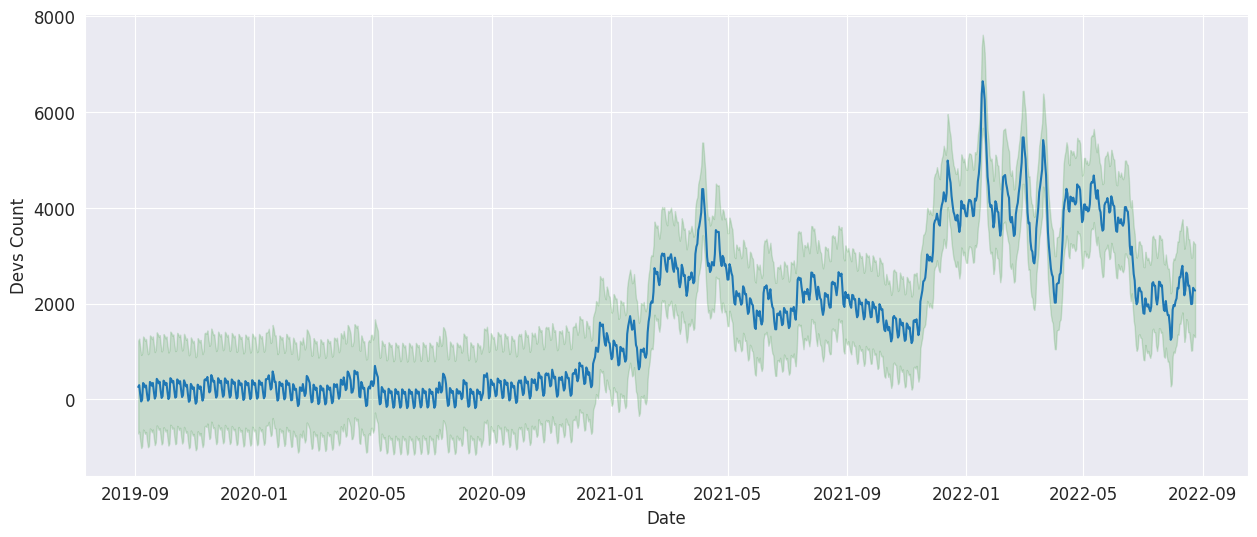

In [28]:
metric = total_signups
period = get_period(metric)

if period == 0:
    period = 365
    print ("Couldn't find a suitable period")
else:
    print("Chosen period -", period)

anomalies = apply_STL(period, metric)
anomalies

Results of Dickey-Fuller Test:
Test Statistic                -1.110789e+01
p-value                        3.723110e-20
#Lags Used                     1.800000e+01
Number of Observations Used    4.470000e+02
Critical Value (1%)           -3.445064e+00
Critical Value (5%)           -2.868028e+00
Critical Value (10%)          -2.570226e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.121791e+01
p-value                        2.047691e-20
#Lags Used                     1.800000e+01
Number of Observations Used    4.470000e+02
Critical Value (1%)           -3.445064e+00
Critical Value (5%)           -2.868028e+00
Critical Value (10%)          -2.570226e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.093089e+01
p-value                        9.830054e-20
#Lags Used                     1.800000e+01
Number of Observations Used    4.390000e+02
Critical Value (1%)           -3.445334e+00
Critical Value (5%)           -2.868146e+

/tmp/ipykernel_226/3564424832.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies['day_name'] = (anomalies.reset_index()['index'].dt.day_name()).values


devs_count         mean  day_name
2021-06-10        1923  1013.000000  Thursday
2021-12-16        2907  1990.714286  Thursday
2022-02-10        2904  1696.571429  Thursday
2022-02-11        2208  1805.714286    Friday
2022-08-09        2002  1424.571429   Tuesday

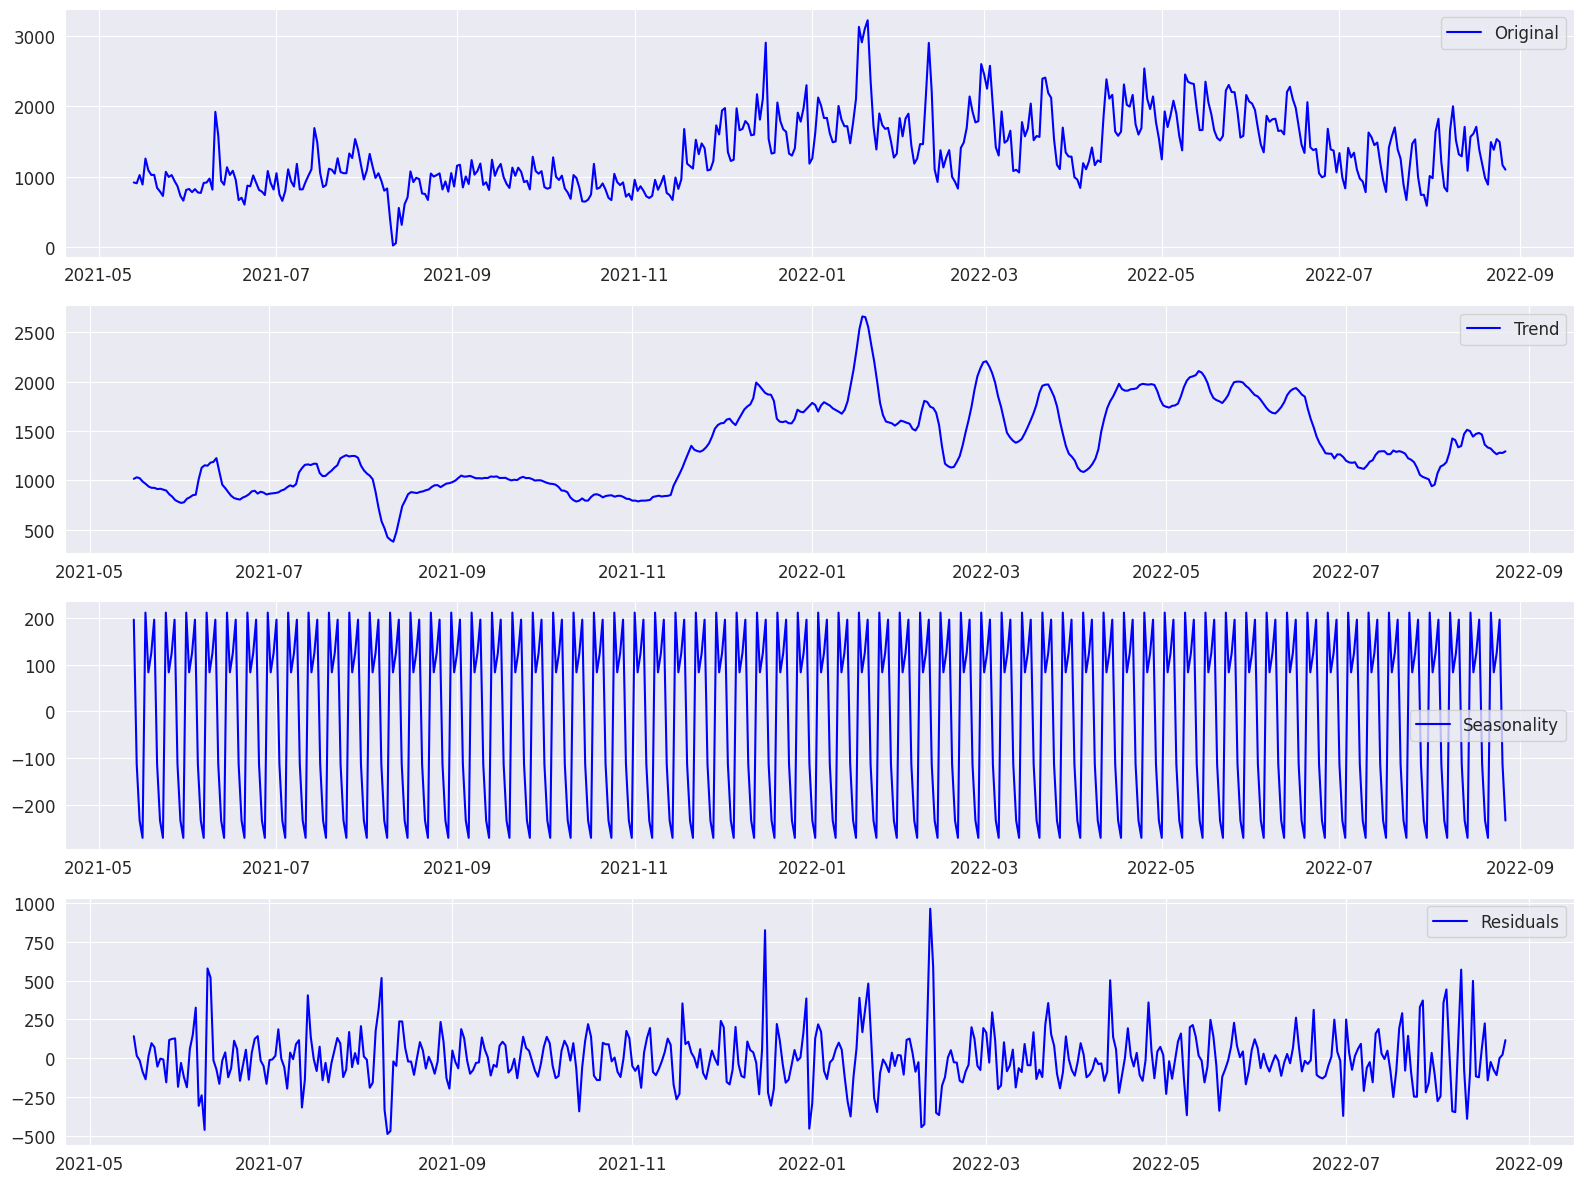

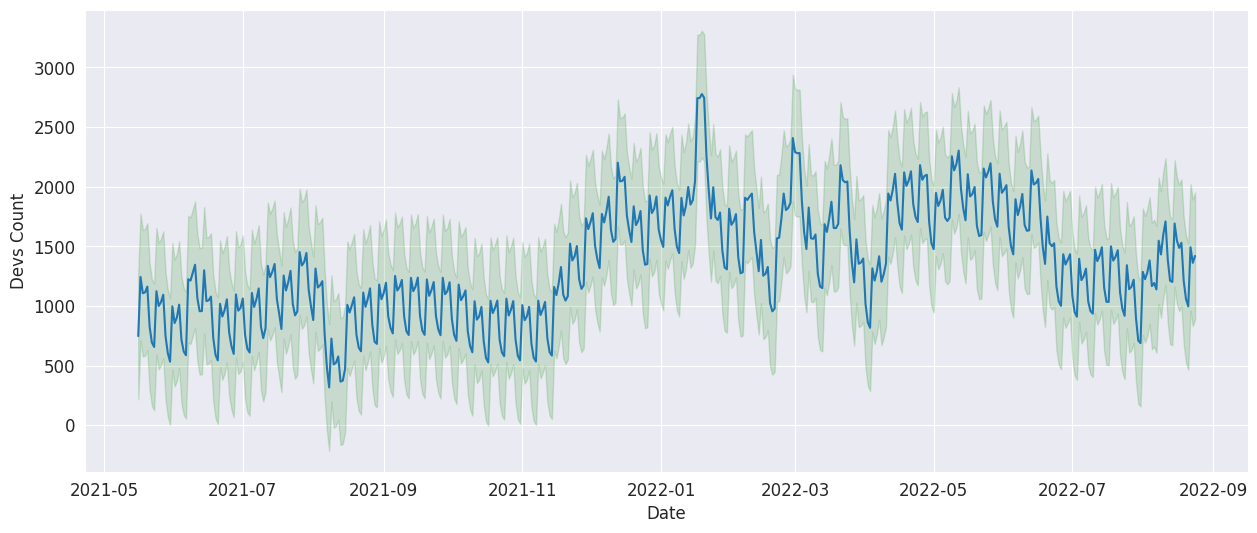

In [29]:
metric = signup_completed
period = get_period(metric)

if period == 0:
    period = 365
    print ("Couldn't find a suitable period")
else:
    print("Chosen period -", period)

anomalies = apply_STL(period, metric)
anomalies

Results of Dickey-Fuller Test:
Test Statistic                -1.430328e+01
p-value                        1.218768e-26
#Lags Used                     1.900000e+01
Number of Observations Used    1.013000e+03
Critical Value (1%)           -3.436822e+00
Critical Value (5%)           -2.864397e+00
Critical Value (10%)          -2.568291e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.391464e+01
p-value                        5.431606e-26
#Lags Used                     1.900000e+01
Number of Observations Used    1.013000e+03
Critical Value (1%)           -3.436822e+00
Critical Value (5%)           -2.864397e+00
Critical Value (10%)          -2.568291e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.179201e+01
p-value                        9.775950e-22
#Lags Used                     2.200000e+01
Number of Observations Used    1.002000e+03
Critical Value (1%)           -3.436893e+00
Critical Value (5%)           -2.864429e+

/tmp/ipykernel_226/3564424832.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies['day_name'] = (anomalies.reset_index()['index'].dt.day_name()).values


devs_count        mean   day_name
2021-03-09          81   40.285714    Tuesday
2021-07-25         126   87.000000     Sunday
2021-08-09         230  116.000000     Monday
2021-08-11          70  122.285714  Wednesday
2021-08-16          56   77.142857     Monday
2021-08-17         190   86.571429    Tuesday
2021-08-19         182  111.571429   Thursday
2022-02-15         140  101.285714    Tuesday
2022-05-05         213  140.714286   Thursday
2022-05-08         111  141.000000     Sunday
2022-05-14         102  140.000000   Saturday
2022-05-17         205  150.000000    Tuesday
2022-05-28          93  155.428571   Saturday
2022-05-29         111  153.571429     Sunday
2022-06-01         268  166.857143  Wednesday
2022-06-02         124  157.571429   Thursday
2022-06-10          97  139.000000     Friday
2022-06-13         194  141.285714     Monday
2022-06-21         189  147.000000    Tuesday
2022-07-20         236  153.000000  Wednesday

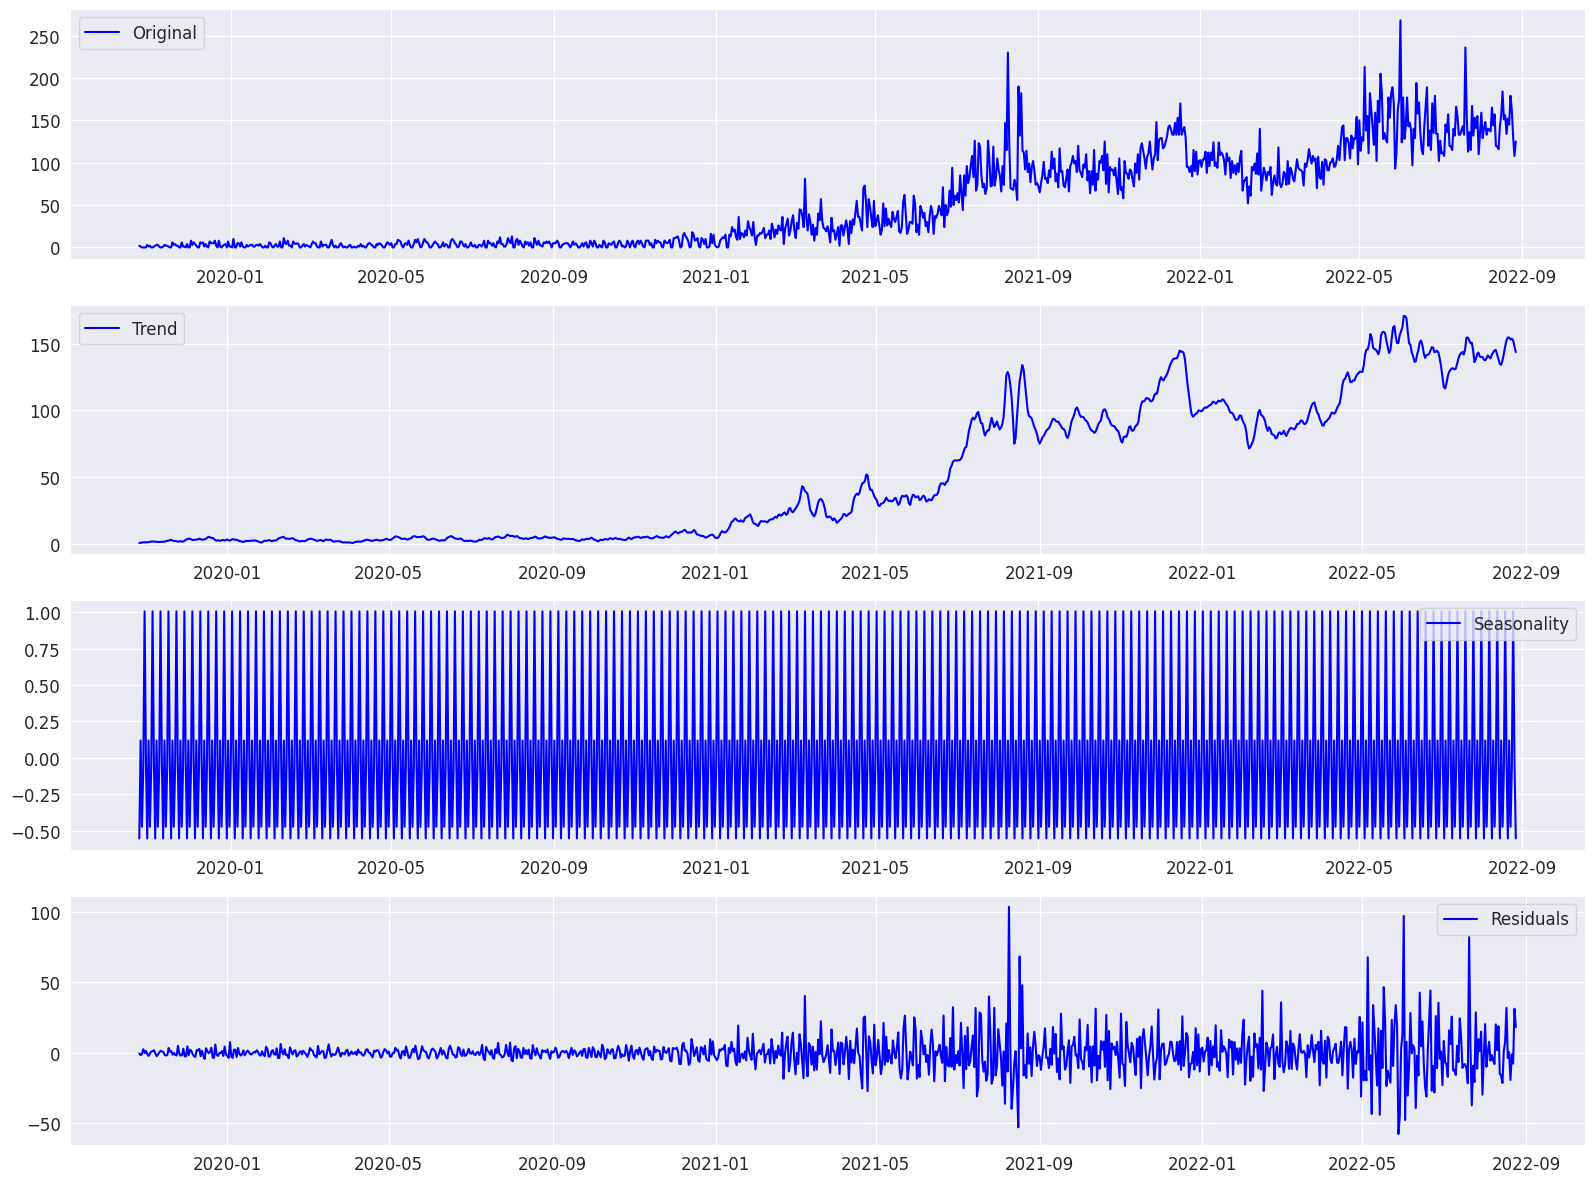

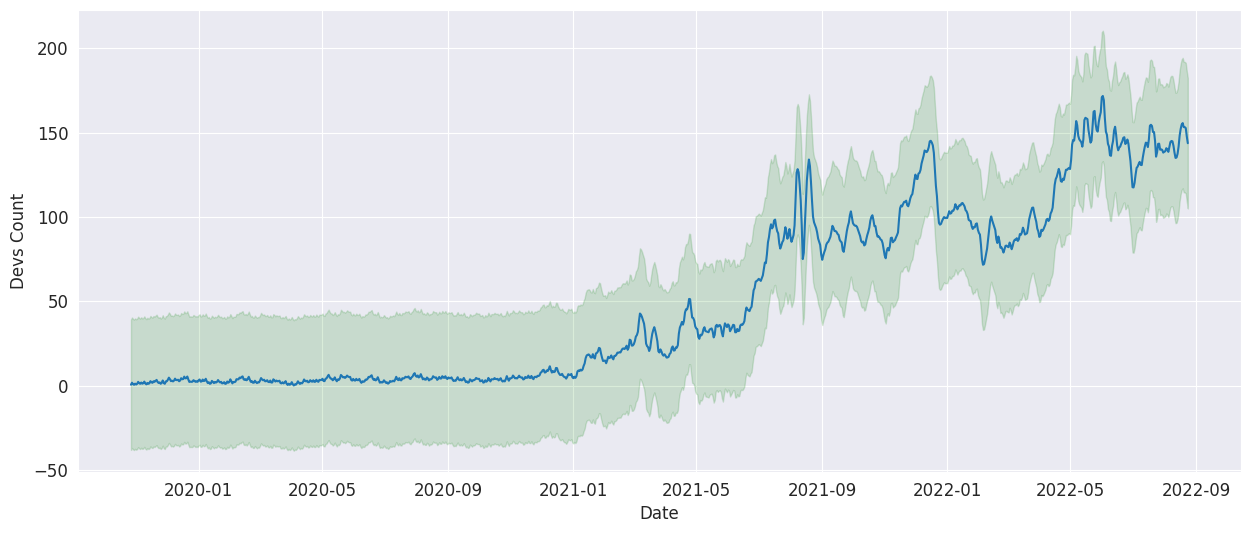

In [30]:
metric = devs_vetted
period = get_period(metric)

if period == 0:
    period = 365
    print ("Couldn't find a suitable period")
else:
    print("Chosen period -", period)

apply_STL(period, metric)

Results of Dickey-Fuller Test:
Test Statistic                -1.422263e+01
p-value                        1.647775e-26
#Lags Used                     2.200000e+01
Number of Observations Used    9.600000e+02
Critical Value (1%)           -3.437180e+00
Critical Value (5%)           -2.864555e+00
Critical Value (10%)          -2.568376e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.218626e+01
p-value                        1.316598e-22
#Lags Used                     2.200000e+01
Number of Observations Used    9.520000e+02
Critical Value (1%)           -3.437238e+00
Critical Value (5%)           -2.864581e+00
Critical Value (10%)          -2.568389e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.215164e+01
p-value                        1.565414e-22
#Lags Used                     2.200000e+01
Number of Observations Used    9.520000e+02
Critical Value (1%)           -3.437238e+00
Critical Value (5%)           -2.864581e+

/tmp/ipykernel_226/2570686409.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies['day_name'] = (anomalies.reset_index()['index'].dt.day_name()).values


devs_count        mean   day_name
2022-03-23         416  207.000000  Wednesday
2022-03-26          20  222.142857   Saturday
2022-04-23          30  276.000000   Saturday
2022-04-24          34  277.571429     Sunday
2022-04-30          15  283.857143   Saturday
2022-05-08          19  251.571429     Sunday
2022-05-22           8  218.000000     Sunday
2022-06-12           3  191.000000     Sunday
2022-07-20         399  215.142857  Wednesday

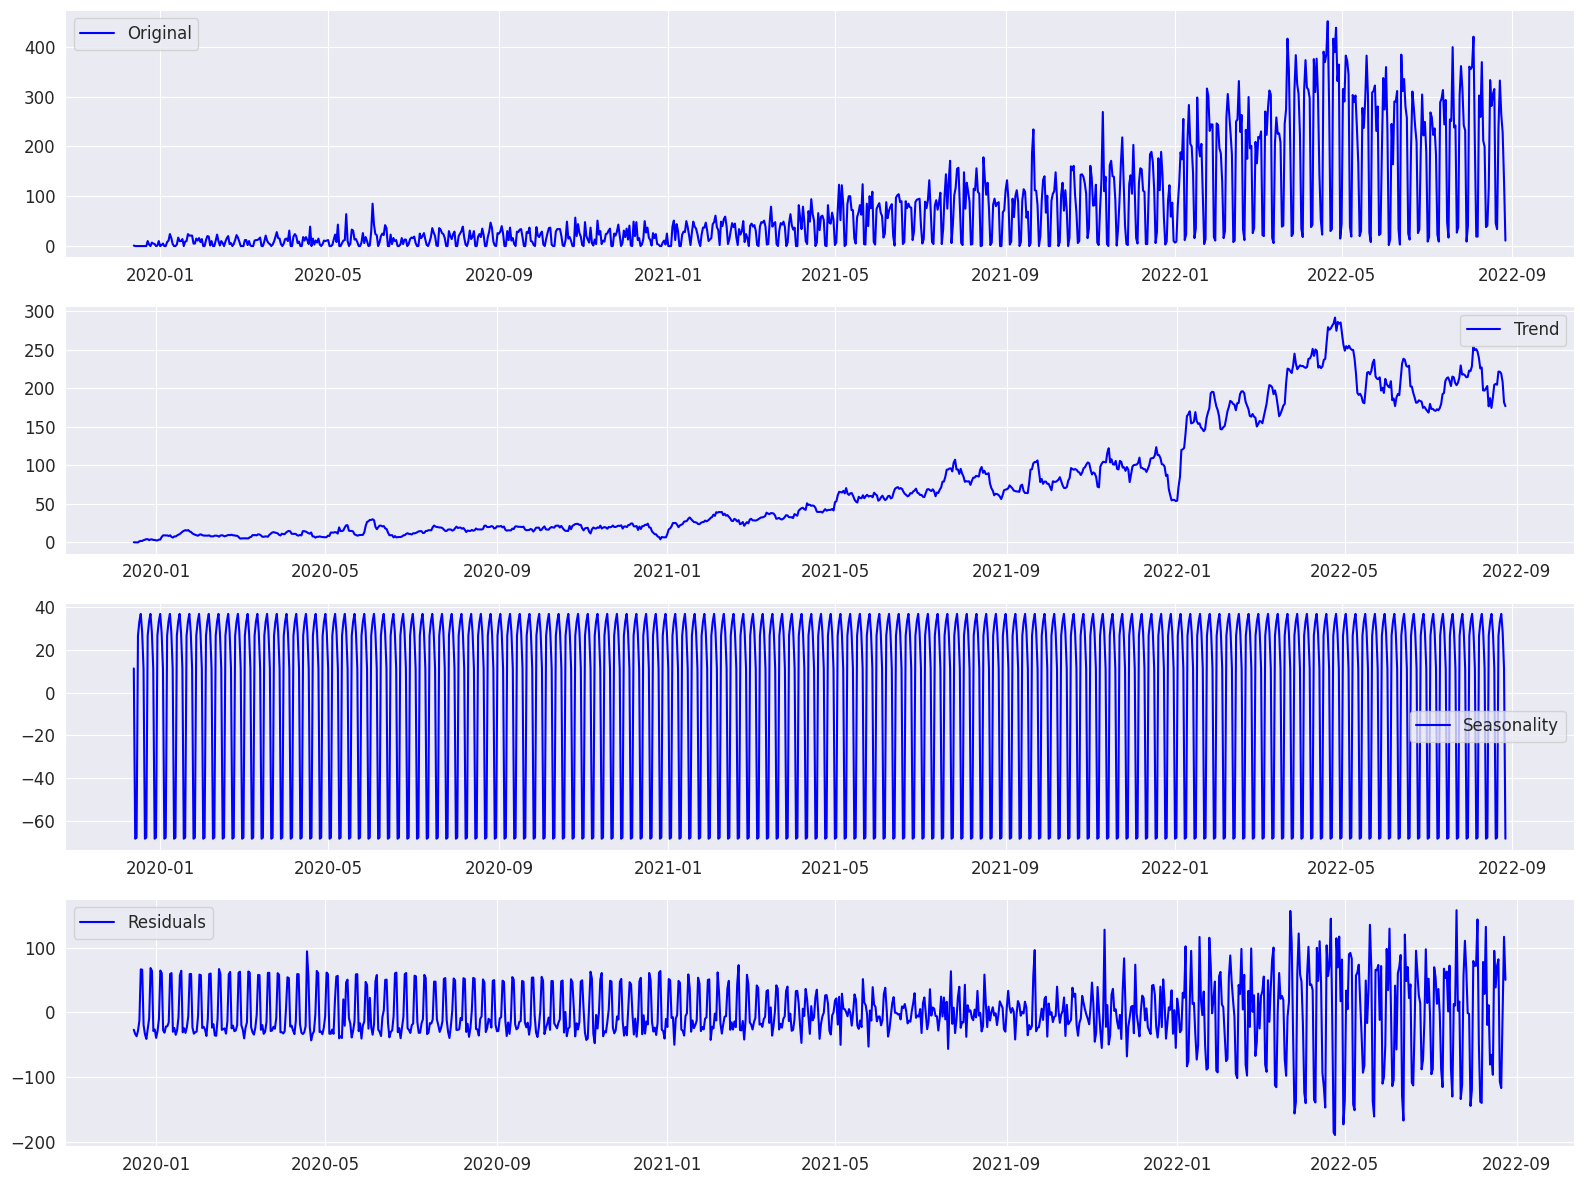

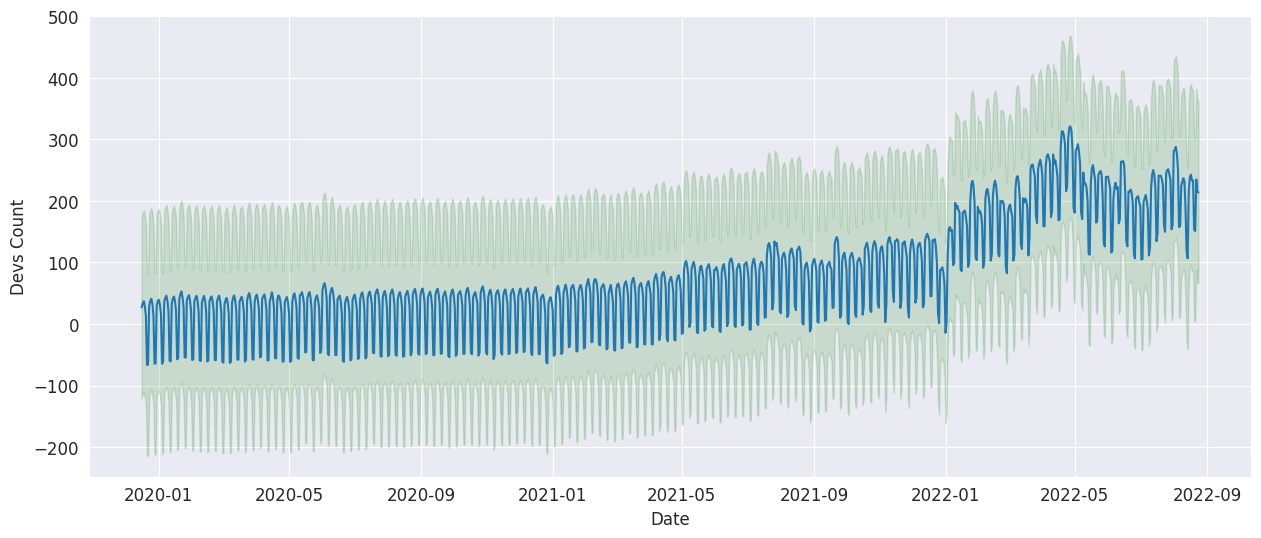

In [34]:
metric = devs_shortlisted
period = get_period(metric)

if period == 0:
    period = 365
    print ("Couldn't find a suitable period")
else:
    print("Chosen period -", period)

apply_STL(period, metric)

Results of Dickey-Fuller Test:
Test Statistic                -1.594291e+01
p-value                        7.505427e-29
#Lags Used                     2.200000e+01
Number of Observations Used    1.009000e+03
Critical Value (1%)           -3.436848e+00
Critical Value (5%)           -2.864409e+00
Critical Value (10%)          -2.568297e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.273815e+01
p-value                        9.065876e-24
#Lags Used                     2.200000e+01
Number of Observations Used    1.001000e+03
Critical Value (1%)           -3.436900e+00
Critical Value (5%)           -2.864432e+00
Critical Value (10%)          -2.568310e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.224542e+01
p-value                        9.808774e-23
#Lags Used                     2.200000e+01
Number of Observations Used    1.001000e+03
Critical Value (1%)           -3.436900e+00
Critical Value (5%)           -2.864432e+

/tmp/ipykernel_226/2570686409.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies['day_name'] = (anomalies.reset_index()['index'].dt.day_name()).values


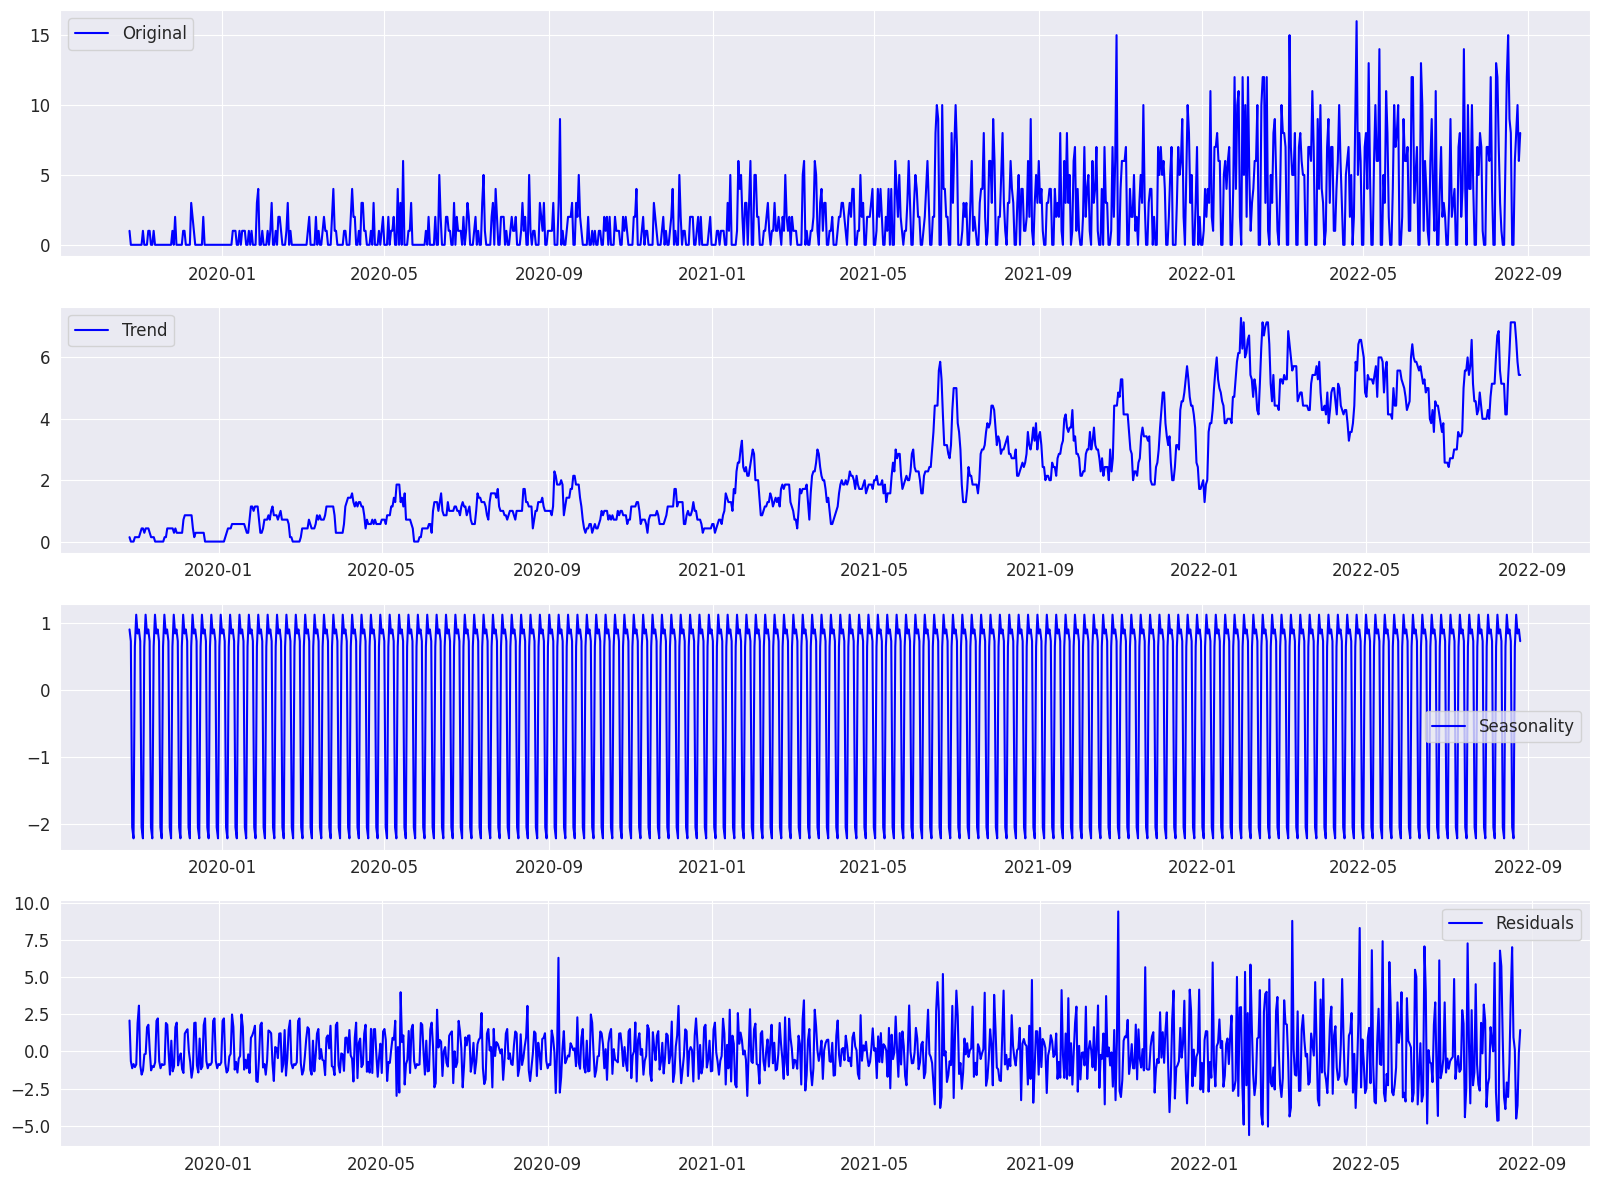

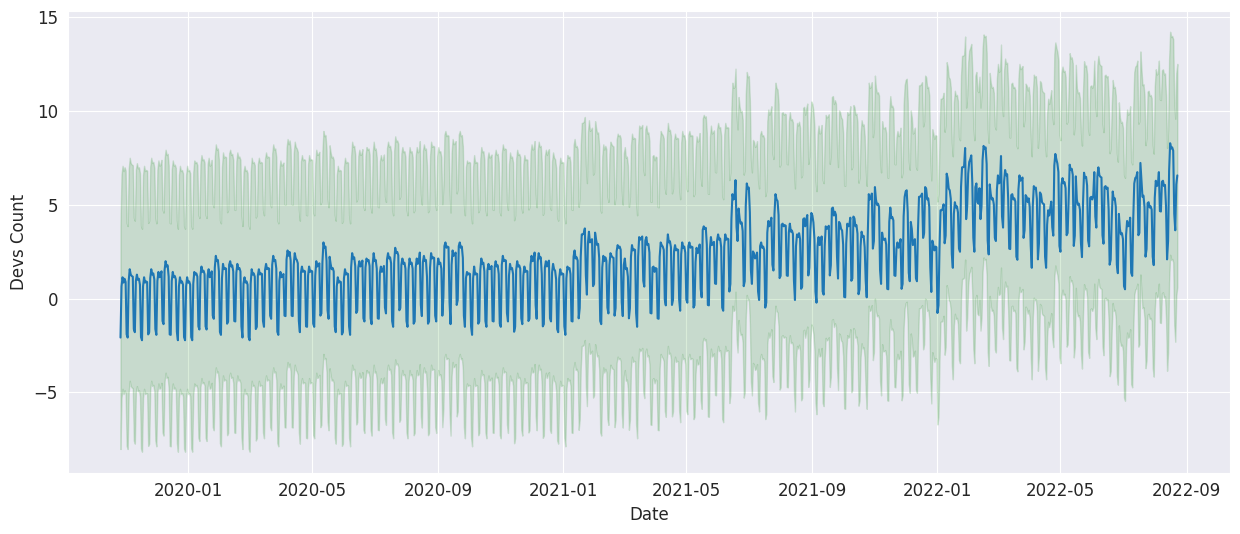

In [35]:
metric = devs_chosen
period = get_period(metric)

if period == 0:
    period = 365
    print ("Couldn't find a suitable period")
else:
    print("Chosen period -", period)

apply_STL(period, metric).to_csv('devs_chosen.csv')